In [1]:
import interface
import convert_file_to_pzformat as converter

# Running SkyNet on the Buzzard DC1 simulation

The following is a demo of how you can use `PhotoZDC1` tools to read in a DC1 simulation file and convert it into a file ready to run with `SkyNet`. `PhotoZDC1` also has functions to convert the DC1 simulation file into the format require for `BPZ`.

Caveat: this is how I ran SkyNet as a newb so it must not be optimal.

The choices made here follow Christopher Bonnett's notebook found [here](http://nbviewer.jupyter.org/urls/bitbucket.org/christopher_bonnett/nn_notebook/raw/6be13d08c10ffc49286227a976754e72283e7543/T-800.ipynb) that runs SkyNet on CFHTLenS data.

## Split training file into training and validation

The 'validation' set here is used by SkyNet to avoid over-training the network.

In [2]:
training_file = '/mnt/drive2/BuzzardSam/Final_Buzzard_training_file.fits'

# there will be two files created:
# outroot_puretrain.fits  (will be used to train the network)
# outroot_validation.fits (will be used as a cross-validation set to prevent over-fitting)
outroot = 'tmp_buzzard'

# the split_training function in interface will simply take one FITS file and split
# it into two FITS files: one for a training set, one for a validation set

# pct_valid is the percentage of the training_file data that should go into 
# the validation set

# redshift_column is the name of the column in the FITS training_file containing the 
# true/spec redshift values
interface.split_training(training_file, outroot, pct_valid=0.2, redshift_column="redshift")

## Write training validation FITS files into SkyNet format

Since the `split_training()` function separated the data into two FITS files, we still need to convert the data in these files into the format required by `SkyNet`.

The reason for doing this as two separate steps is that the two FITS files can be converted to multiple formats ready for analysis with multiple photo-z algorithms. 

In [3]:
# the final SkyNet format files will be called:
# outroot_train.txt and outroot_test.txt (as required by SkyNet)
outroot = 'buzzard'

# a list of the column names of all the 'input' features
input_cols = ['LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy', 
              'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']

# a list of the column names of all the 'output' features 
# (i.e. features to be estimated)
output_cols = ['redshift']

# these first two files were the ones we made in the last section
converter.convert_fits_to_skynet('tmp_buzzard_puretrain.fits', 
                                 'tmp_buzzard_validation.fits', 
                                 input_cols, 
                                 output_cols, 
                                 outroot)

## Double check the data

The module `photoz_fileparser` reads photo-z algorithm formatted data files into pandas data frame


In [4]:
import photoz_fileparser as pzparse

# this is the file we just created by running convert_fits_to_skynet
training_file = 'buzzard_train.txt'

# read a SkyNet format file into a pandas dataframe
training_df = pzparse.read_skynet_file(training_file)

# the 'input' columns are just named Input0 through Input[n-1]
# similarly for the 'output' columns
training_df.head()

number of inputs = 12
number of outputs = 1


,Input0,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Output0
0,26.5434,26.1641,25.3686,24.6524,24.3431,24.4618,0.2620,0.0645,0.0322,0.0290,0.0444,0.1172,0.792904
1,26.9463,27.3066,26.8962,26.4418,25.7755,25.2387,0.6666,0.1853,0.1242,0.1585,0.1894,0.3482,1.283890
2,27.2753,27.2977,26.5773,25.7550,25.2073,24.8882,0.6750,0.1975,0.0878,0.0772,0.0835,0.1808,0.942039
3,27.9558,27.2621,26.9265,26.1160,25.8837,25.5714,0.4834,0.1501,0.1012,0.1152,0.1636,0.3986,0.953136
4,28.2015,26.9766,25.7396,25.6064,25.2239,25.1185,0.6999,0.1157,0.0417,0.0597,0.0930,0.2519,0.356240


If we plot histograms of the magnitudes and magnitude errors we can see what the features that will go into the neural network model will look like.

There are a signficant number of non-detections with magnitude values very different (~99) from the magnitude values of detected galaxies. However it's unclear what kind of magnitude errors these galaxies have relative to galaxies that were detected but might be faint.

Because the data file was selected so all galaxies have $i<27$ there are no non-detections in the $i$ filter

Number non-detects in u = 7234
Mean mag error on non-detects in u = 1.43658306608 

Number non-detects in g = 352
Mean mag error on non-detects in g = 0.774017613636 

Number non-detects in r = 5
Mean mag error on non-detects in r = 0.46394 

Number non-detects in i = 0
Mean mag error on non-detects in i = nan 

Number non-detects in z = 18
Mean mag error on non-detects in z = 0.455294444444 

Number non-detects in y = 1153
Mean mag error on non-detects in y = 0.735233130963 



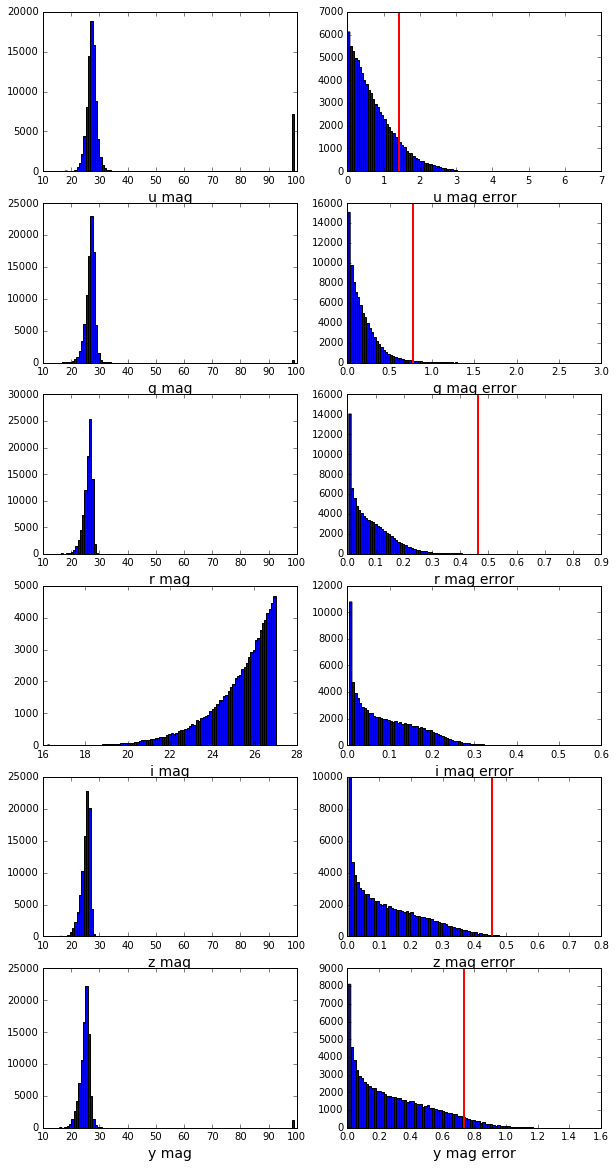

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# This LSST data set has 6 filters
nFilters = 6

filts = ['u','g','r','i','z','y']

fig = plt.figure(figsize=(10,20))
for i in range(nFilters):
    
    imag = 2*i + 1
    ierror = imag + 1
    
    ax = fig.add_subplot(6,2,imag)
    ax.hist(training_df["Input"+str(i)], 100)
    ax.set_xlabel(filts[i] + ' mag', fontsize=14)
    
    ax = fig.add_subplot(6,2,ierror)
    ax.hist(training_df["Input"+str(i+nFilters)], 100)
    ax.set_xlabel(filts[i] + ' mag error', fontsize=14)
    
    inon_detect = (training_df["Input"+str(i)]>90.)
    
    print 'Number non-detects in', filts[i], '=', len(training_df[inon_detect])
    
    
    mean_err = training_df["Input"+str(i+nFilters)][inon_detect].mean()
    print 'Mean mag error on non-detects in', filts[i], '=', mean_err, '\n'
    
    ylims = ax.get_ylim()
    ax.plot([mean_err, mean_err], ylims, color='red', linewidth=2)
    

Looking at the relative histograms of magnitude errors of detected and non-detected galaxies there appears to be some overlap in their values. In fact often the maximum value of a detected galaxy's magnitude error is *less* than the maximum value of a non-detected galaxy's magnitude error.

Maximum magnitude error in u = 6.1667
Maximum magnitude error of detected galaxy = 5.4906
Maximum magnitude error of non-detected galaxy = 6.1667
Maximum magnitude of detected galaxy = 39.0516 

Maximum magnitude error in g = 2.7577
Maximum magnitude error of detected galaxy = 2.7577
Maximum magnitude error of non-detected galaxy = 2.1672
Maximum magnitude of detected galaxy = 37.9513 

Maximum magnitude error in r = 0.8234
Maximum magnitude error of detected galaxy = 0.8234
Maximum magnitude error of non-detected galaxy = 0.5263
Maximum magnitude of detected galaxy = 32.9314 

Maximum magnitude error in i = 0.5616
Maximum magnitude error of detected galaxy = 0.5616
Maximum magnitude error of non-detected galaxy = nan
Maximum magnitude of detected galaxy = 27.0 

Maximum magnitude error in z = 0.7806
Maximum magnitude error of detected galaxy = 0.7806
Maximum magnitude error of non-detected galaxy = 0.6006
Maximum magnitude of detected galaxy = 32.6642 

Maximum magnitude error in y = 

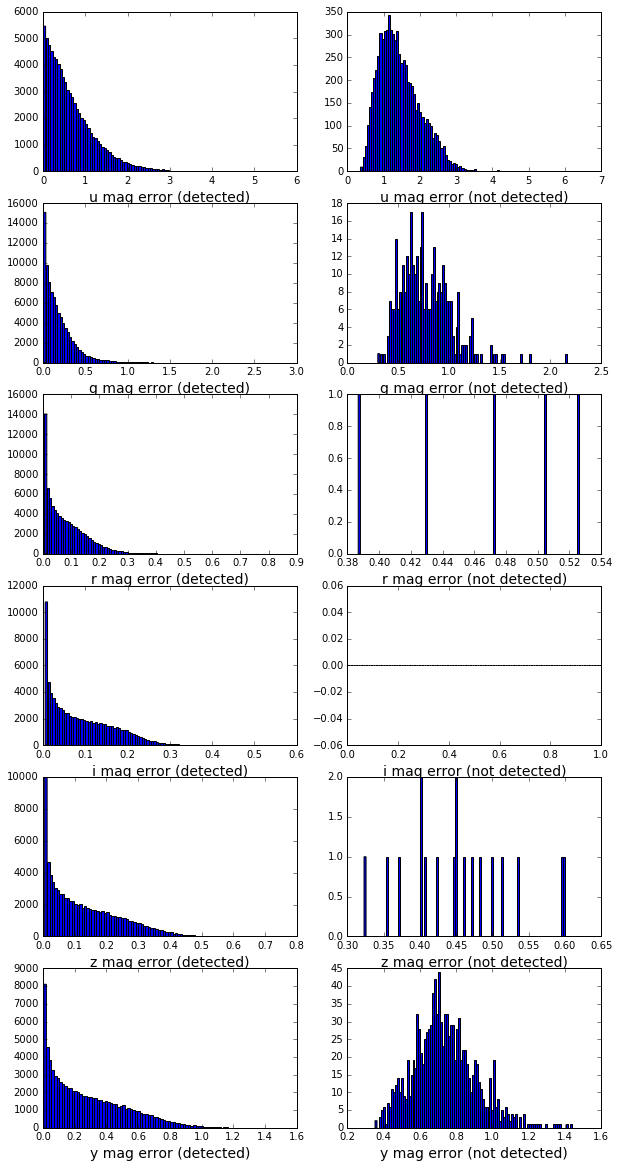

In [6]:
fig = plt.figure(figsize=(10,20))
for i in range(nFilters):
    
    idet = 2*i + 1
    inondet = idet + 1
    
    # find all galaxies detected in filter
    idetect = (training_df["Input"+str(i)]<90.)
    
    # find all galaxies not detected in filter
    inon_detect = (training_df["Input"+str(i)]>=90.)
    
    # just double checking these summed to the total number of galaxies
    # print len(training_df[idetect])+len(training_df[inon_detect]), len(training_df)
    
    ax = fig.add_subplot(6,2,idet)
    ax.hist(training_df["Input"+str(i+nFilters)][idetect], 100)
    ax.set_xlabel(filts[i] + ' mag error (detected)', fontsize=14)
    
    ax = fig.add_subplot(6,2,inondet)
    ax.hist(training_df["Input"+str(i+nFilters)][inon_detect], 100)
    ax.set_xlabel(filts[i] + ' mag error (not detected)', fontsize=14)
    
    print "Maximum magnitude error in", filts[i], '=', 
    print training_df["Input"+str(i+nFilters)].max()
    
    print "Maximum magnitude error of detected galaxy =", 
    print training_df["Input"+str(i+nFilters)][idetect].max()
    
    print "Maximum magnitude error of non-detected galaxy =", 
    print training_df["Input"+str(i+nFilters)][inon_detect].max()
    
    print "Maximum magnitude of detected galaxy =", 
    print training_df["Input"+str(i)][idetect].max(), '\n'

## Reset values of non-detections

`SkyNet` has the option to "whiten" the data, by which they mean basically normalise the data. There are two options you can select: the standard way of normalising, which is to transform the distribution of each feature into a standard normal distribution by subtracting its mean and dividing by its standard deviation. The other way (which is the default option) is to scale and shift the data onto the $[0,1]$ interval by subtracting the minimum of each feature then dividing by its range.

We wish to normalise the data because it's hard to train models with features that have ranges that take significantly different sized typical values (e.g. $20<m<27$ and $0<err<0.1$ ish).

Therefore I will set every non-detection magnitude equal to 42, a value that is outside the range of detected magnitudes, but not by much.

In [7]:
# also read test/validation data into a dataframe
test_file = 'buzzard_test.txt'
test_df = pzparse.read_skynet_file(test_file)

# Grab correct column names
input_cols = [col for col in list(training_df.columns) if col.startswith('Input')]
output_cols = [col for col in list(training_df.columns) if col.startswith('Output')]


# fix all non-detection values
new_non_detect_value = 42.

for i in range(nFilters):
    
    # for training 
    inon_detect = (training_df["Input"+str(i)]>=90.)
    training_df["Input"+str(i)][inon_detect] = new_non_detect_value
    
    # for test/validation 
    inon_detect = (test_df["Input"+str(i)]>=90.)
    test_df["Input"+str(i)][inon_detect] = new_non_detect_value
    
print training_df[input_cols].max()
print test_df[input_cols].max()

# write new training file
ftrain = training_file.split('_')[0] + "_fixed_nondets_train.txt"
converter.write_skynet_data(ftrain, training_df, input_cols, output_cols)

# write new test file
ftest = test_file.split('_')[0] + "_fixed_nondets_test.txt"
converter.write_skynet_data(ftest, test_df, input_cols, output_cols)

number of inputs = 12
number of outputs = 1
Input0     42.0000
Input1     42.0000
Input2     42.0000
Input3     27.0000
Input4     42.0000
Input5     42.0000
Input6      6.1667
Input7      2.7577
Input8      0.8234
Input9      0.5616
Input10     0.7806
Input11     1.5997
dtype: float64
Input0     42.0000
Input1     42.0000
Input2     42.0000
Input3     27.0000
Input4     42.0000
Input5     42.0000
Input6      5.4729
Input7      1.9788
Input8      0.8709
Input9      0.6585
Input10     0.8249
Input11     1.5560
dtype: float64


## Create .inp file

The `.inp` file contains all the parameters needed to run `SkyNet` with.

In [8]:
reload(converter)

# this will be the name of the .inp file created
inp_file_name = 'buzzard.inp'

# the root of the training and test/validation filenames (up to [train|test].txt)
input_root = training_file.split('_')[0] + "_fixed_nondets_"

# file stem output files will be written to
output_root = '/mnt/drive2/alex/skynet_runs/test/buzzard_'

# 3 hidden layers, with 20, 40, 40 nodes
hidden_layers_nodes = [20,40,40]

# create file
converter.create_inp_file(inp_file_name,
                        input_root,
                        output_root,
                        hidden_layers_nodes)

## Run SkyNet

SkyNet takes a long time to train: but this only needs to be done once!

In [9]:
import subprocess
import time

start_time = time.time()
subprocess.call('SkyNet ' + inp_file_name, shell=True)
end_time = time.time()
print "Time to run =", (end_time-start_time)/3600., "hours"

Time to run = 95.1131142778 hours


# Results

Read the results from the test/validation file and the original data from the test/validation file into dataframes.

In [28]:
reload(interface)
import photoz_fileparser as pzparse

# results in dataframe
test_results = '/mnt/drive2/alex/skynet_runs/test/buzzard_test_pred.txt'
test_catalog = interface.ReadCosmoSim(test_results, delimiter='\t', header=None)
test_df = test_catalog._data
test_df.head()

# original test sample
test_data = 'buzzard_test.txt'
test_orig_df = pzparse.read_skynet_file(test_data)


number of inputs = 12
number of outputs = 1


In [29]:
# The original test/validation file
test_orig_df.head()

,Input0,Input1,Input2,Input3,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Output0
0,27.2922,27.0443,25.9475,25.9361,25.7488,25.1920,0.6397,0.1290,0.0540,0.0848,0.1411,0.3785,0.388203
1,26.0888,25.3318,23.9306,22.7578,22.3022,22.0113,0.2286,0.0343,0.0095,0.0072,0.0084,0.0163,0.742239
2,28.7434,28.1299,27.6014,26.4343,26.4707,27.4706,1.6625,0.4404,0.1815,0.1755,0.2850,0.6274,0.669821
3,27.9090,26.7033,24.6031,23.5082,22.5035,21.8340,0.6893,0.1099,0.0155,0.0114,0.0095,0.0147,1.044960
4,31.0761,27.7472,27.5220,26.8381,26.1738,26.7204,1.5889,0.4043,0.1718,0.1728,0.2794,0.6109,0.652479


In [30]:
# lack of column names in file means pandas just names them 0:N-1
test_df.head()

# the columns are the same as the original file, 
# but with the estimated photo-z in the last column

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,27.292200,27.044300,25.947502,25.936100,25.748802,25.192001,0.6397,0.1290,0.0540,0.0848,0.1411,0.3785,0.388203,0.365361,NaN
1,26.088800,25.331800,23.930599,22.757801,22.302200,22.011301,0.2286,0.0343,0.0095,0.0072,0.0084,0.0163,0.742239,0.732065,NaN
2,28.743402,28.129900,27.601402,26.434299,26.470699,27.470600,1.6625,0.4404,0.1815,0.1755,0.2850,0.6274,0.669821,0.639966,NaN
3,27.909000,26.703302,24.603102,23.508200,22.503500,21.834000,0.6893,0.1099,0.0155,0.0114,0.0095,0.0147,1.044960,1.032159,NaN
4,31.076099,27.747202,27.521999,26.838100,26.173800,26.720400,1.5889,0.4043,0.1718,0.1728,0.2794,0.6109,0.652479,0.649813,NaN


## Statistics

Global values (i.e. across all redshifts) of the bias and $\sigma$ only just meet LSST requirements, and actually are a bit worse for the Gold sample?

In [13]:
import photo_z as pz

In [40]:
### Global estimates
print "Raw global stats:"
g = pz.global_stats(test_df[13],  test_df[12])

print "Gold global stats:"
iGold = (test_df[3]<=25.3) & (test_df[3]>0)
gg = pz.global_stats(test_df[13],  test_df[12], iGold)

Raw global stats:
global sigma: 0.040 global bias: -0.001
global IQR: 0.035 global IQR-sigma: 0.026
total number = 22235 

Gold global stats:
global sigma: 0.043 global bias: -0.001
global IQR: 0.038 global IQR-sigma: 0.028
number selected = 8821 



In [33]:
# for convenience add the pre-calculated e_z to the dataframe
# true-z is in column 12 (passed as series)
# photo-z is in column 13 (passed as column name)
pz.add_ez_column(test_df, test_df[12], photo_z=13, col_name="ez")
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,ez
0,27.292200,27.044300,25.947502,25.936100,25.748802,25.192001,0.6397,0.1290,0.0540,0.0848,0.1411,0.3785,0.388203,0.365361,NaN,-0.016454
1,26.088800,25.331800,23.930599,22.757801,22.302200,22.011301,0.2286,0.0343,0.0095,0.0072,0.0084,0.0163,0.742239,0.732065,NaN,-0.005840
2,28.743402,28.129900,27.601402,26.434299,26.470699,27.470600,1.6625,0.4404,0.1815,0.1755,0.2850,0.6274,0.669821,0.639966,NaN,-0.017879
3,27.909000,26.703302,24.603102,23.508200,22.503500,21.834000,0.6893,0.1099,0.0155,0.0114,0.0095,0.0147,1.044960,1.032159,NaN,-0.006260
4,31.076099,27.747202,27.521999,26.838100,26.173800,26.720400,1.5889,0.4043,0.1718,0.1728,0.2794,0.6109,0.652479,0.649813,NaN,-0.001613


## Histogram of $(z_p-z)/(1+z)$

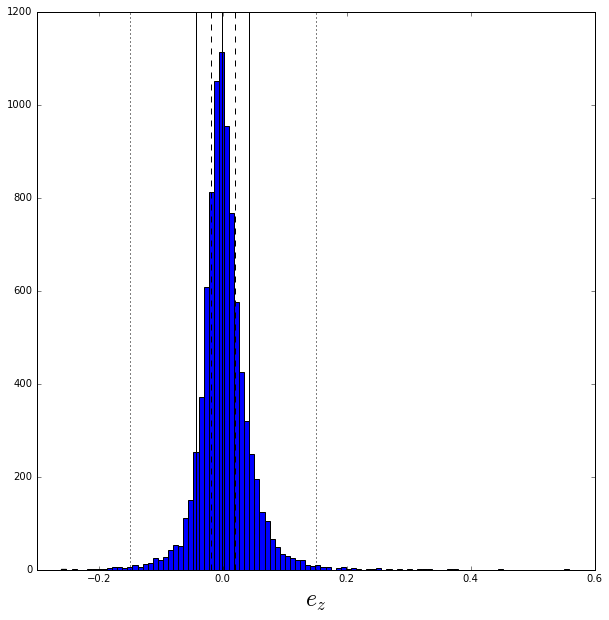

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

### Plot histogram
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.histogram_ez(test_df["ez"], ax, selection=iGold, plot_stats=True, bins=100)
ax.set_xlabel('$e_z$', fontsize=24)

## Scatter plot $z_p$ vs $z$

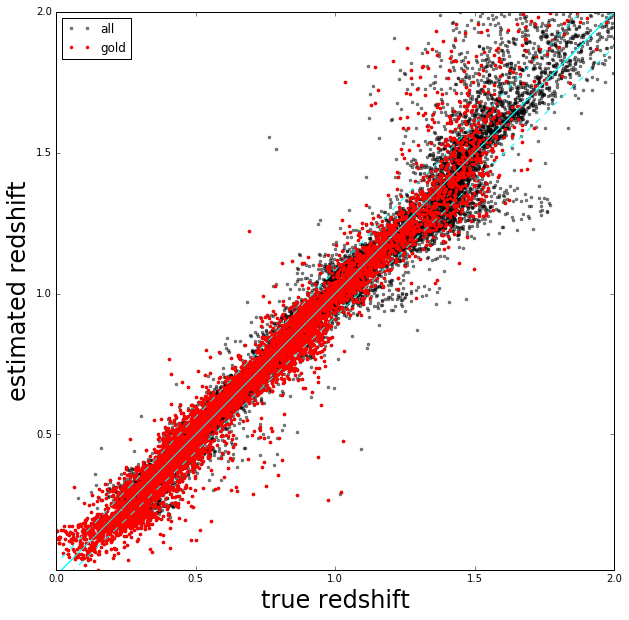

In [36]:
### Plot scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.photoz_vs_z(test_df[12], test_df[13],
               ax, plot_sigs=False, guide_color='cyan', 
               color='black', alpha=0.5, label='all',
               marker='.', linestyle='none')
pz.photoz_vs_z(test_df[12], test_df[13],
               ax, selection=iGold, plot_sigs=True, guide_color='cyan', 
               color='red', label='gold',
               marker='.', linestyle='none')
ax.set_xlim([0,2])
ax.set_xlabel('true redshift', fontsize=24)
ax.set_ylabel('estimated redshift', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12}, loc='upper left')

## Statisics as a function of redshift

This run doesn't quite meet LSST requirements (note $\sigma$ requirement is really $\sigma<0.05$), at least not at all redshifts

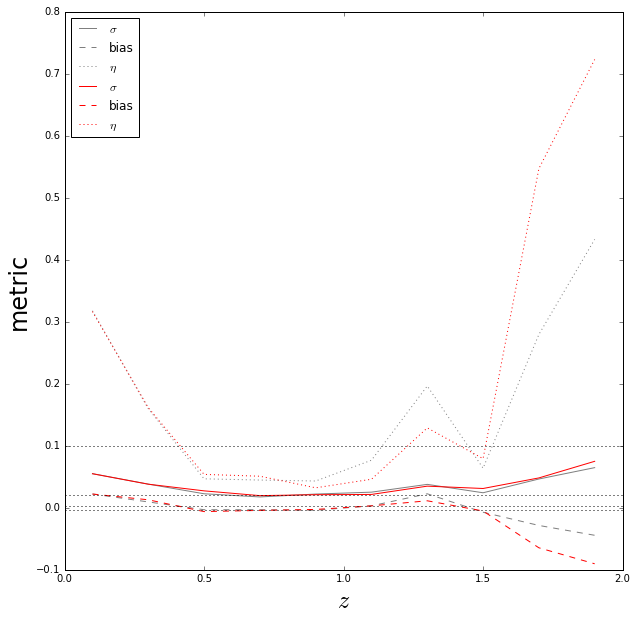

In [37]:

### Plot stats vs z on one plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.all_stats_vs_redshift(test_df, 13, 12, ax, 
                         color='black', alpha=0.5)
pz.all_stats_vs_redshift(test_df, 13, 12, ax, iGold, color='red')
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('metric', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12}, loc='upper left')
pz.add_LSST_req(ax, req_type='SIGMA', linestyle='dotted', color='black')
pz.add_LSST_req(ax, req_type='BIAS', linestyle='dotted', color='black')
pz.add_LSST_req(ax, req_type='OUTLIER', linestyle='dotted', color='black')

SIGMA
BIAS
OUTLIER
CATASTROPHIC


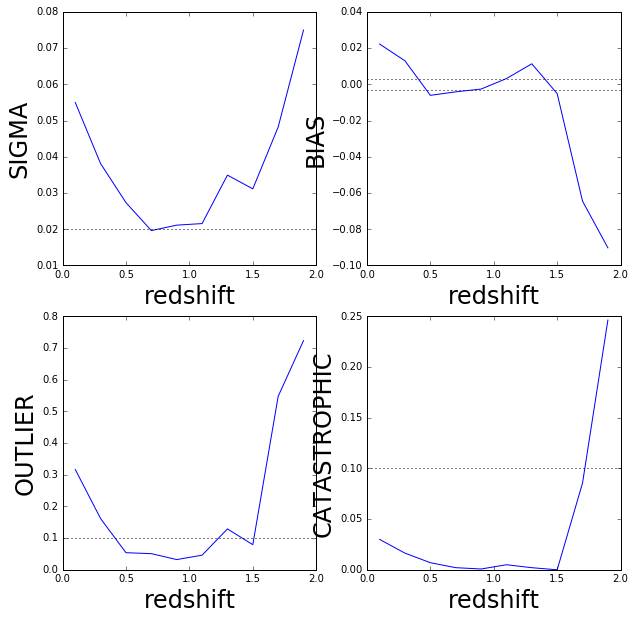

In [41]:
stats = ['SIGMA', 'BIAS', 'OUTLIER', 'CATASTROPHIC']

### Plot stats separately
fig = plt.figure(figsize=(10,10))

for i,s in enumerate(stats):
    ax = fig.add_subplot(2,2,i+1)

    pz.one_stat_vs_redshift(test_df, 13, 12,  
                            ax, stat=s, selection=iGold, zbins=[0,2,0.2])
    ax.set_xlabel('redshift', fontsize=24)
    ax.set_ylabel(s, fontsize=24)
    #if i<3:
    print s
    pz.add_LSST_req(ax, req_type=s, linestyle='dotted', color='black')

## $n(z)$

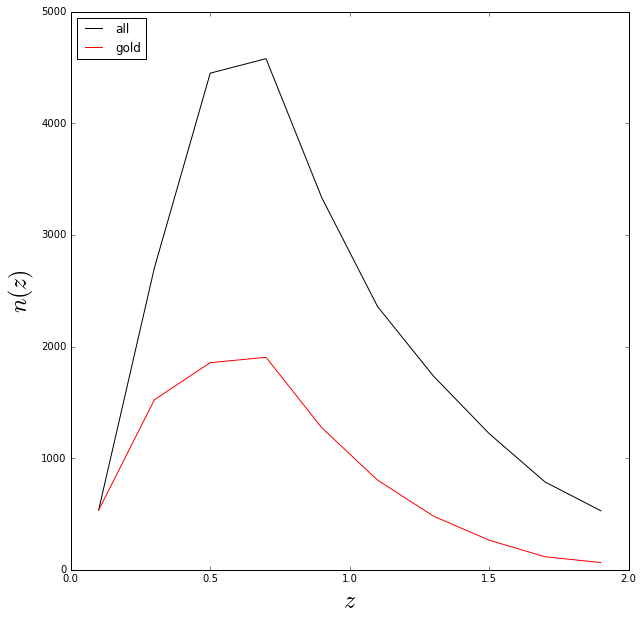

In [42]:
### Plot n(z)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.n_of_z(test_df, "ez", 12, ax, color='black', label='all')
pz.n_of_z(test_df, "ez", 12, ax, iGold, color='red', label='gold')
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$n(z)$', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(prop={'size':12}, loc='upper left')

## $z_p$ distribution with $z$

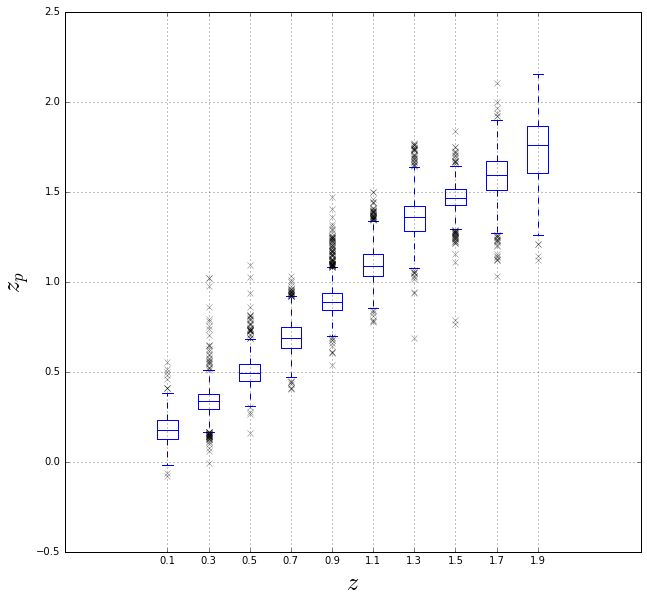

In [39]:
### Plot distribution
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
pz.distribution_vs_redshift(test_df, 13, 12, ax)
ax.set_xlabel('$z$', fontsize=24)
ax.set_ylabel('$z_p$', fontsize=24)

# Double check for over-/under-training

Repeat above plots for training set data

In [46]:
# results in dataframe
train_results = '/mnt/drive2/alex/skynet_runs/test/buzzard_train_pred.txt'
train_catalog = interface.ReadCosmoSim(train_results, delimiter='\t', header=None)
train_df = train_catalog._data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,26.543402,26.164101,25.368603,24.652401,24.343100,24.461800,0.2620,0.0645,0.0322,0.0290,0.0444,0.1172,0.792904,0.763363,NaN
1,26.946301,27.306602,26.896200,26.441799,25.775499,25.238701,0.6666,0.1853,0.1242,0.1585,0.1894,0.3482,1.283890,1.450825,NaN
2,27.275299,27.297703,26.577299,25.754999,25.207302,24.888201,0.6750,0.1975,0.0878,0.0772,0.0835,0.1808,0.942039,0.919659,NaN
3,27.955799,27.262100,26.926502,26.116001,25.883699,25.571400,0.4834,0.1501,0.1012,0.1152,0.1636,0.3986,0.953136,0.903377,NaN
4,28.201500,26.976601,25.739599,25.606401,25.223900,25.118500,0.6999,0.1157,0.0417,0.0597,0.0930,0.2519,0.356240,0.330209,NaN


In [47]:
### Global estimates
print "Raw global stats:"
g = pz.global_stats(train_df[13],  train_df[12])

print "Gold global stats:"
iGold = (train_df[3]<=25.3) & (train_df[3]>0)
gg = pz.global_stats(train_df[13],  train_df[12], iGold)

Raw global stats:
global sigma: 0.040 global bias: -0.001
global IQR: 0.035 global IQR-sigma: 0.026
total number = 88936 

Gold global stats:
global sigma: 0.042 global bias: -0.001
global IQR: 0.038 global IQR-sigma: 0.028
number selected = 35594 



In [48]:
pz.add_ez_column(train_df, train_df[12], photo_z=13, col_name="ez")
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,ez
0,26.543402,26.164101,25.368603,24.652401,24.343100,24.461800,0.2620,0.0645,0.0322,0.0290,0.0444,0.1172,0.792904,0.763363,NaN,-0.016477
1,26.946301,27.306602,26.896200,26.441799,25.775499,25.238701,0.6666,0.1853,0.1242,0.1585,0.1894,0.3482,1.283890,1.450825,NaN,0.073092
2,27.275299,27.297703,26.577299,25.754999,25.207302,24.888201,0.6750,0.1975,0.0878,0.0772,0.0835,0.1808,0.942039,0.919659,NaN,-0.011524
3,27.955799,27.262100,26.926502,26.116001,25.883699,25.571400,0.4834,0.1501,0.1012,0.1152,0.1636,0.3986,0.953136,0.903377,NaN,-0.025476
4,28.201500,26.976601,25.739599,25.606401,25.223900,25.118500,0.6999,0.1157,0.0417,0.0597,0.0930,0.2519,0.356240,0.330209,NaN,-0.019194


SIGMA
BIAS
OUTLIER
CATASTROPHIC


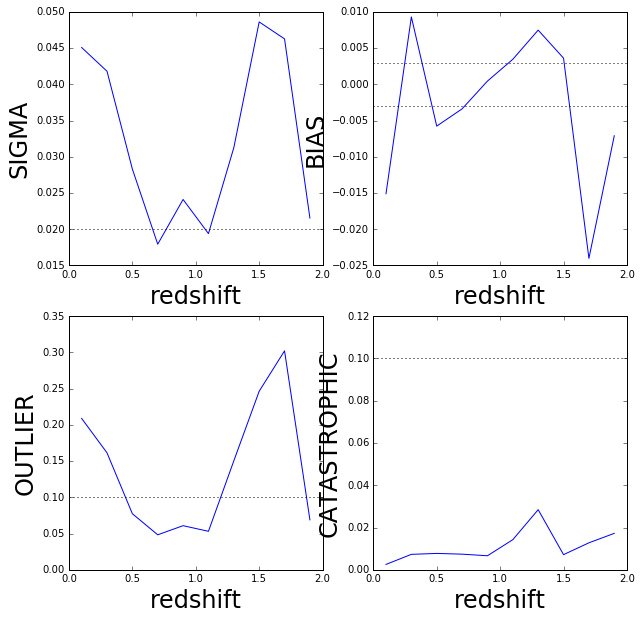

In [49]:
### Plot stats separately
fig = plt.figure(figsize=(10,10))

for i,s in enumerate(stats):
    ax = fig.add_subplot(2,2,i+1)

    pz.one_stat_vs_redshift(train_df, 12, 13,  
                            ax, stat=s, selection=iGold, zbins=[0,2,0.2])
    ax.set_xlabel('redshift', fontsize=24)
    ax.set_ylabel(s, fontsize=24)
    #if i<3:
    print s
    pz.add_LSST_req(ax, req_type=s, linestyle='dotted', color='black')

This network looks a little over trained, though this is mostly effecting the edges (data at high and low $z$)